In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.signal import argrelextrema
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [42]:
drilldf = pd.read_csv('./impactdrill.csv')
glovedf = pd.read_csv('./leathersafetygloves.csv')
kurtadf = pd.read_csv('./ladieskurta.csv')

In [43]:
drilldf.head()

,Category Name,Unit,Price
0,Impact Drill,Piece,2
1,Impact Drill,Piece,675
2,Impact Drill,Piece,766
3,Impact Drill,Piece,900
4,Impact Drill,Piece,1000


In [44]:
glovedf.head()

,Category Name,Unit,Price
0,Leather Safety Gloves,Pair,10
1,Leather Safety Gloves,Pair,12
2,Leather Safety Gloves,Pair,12
3,Leather Safety Gloves,Pair,20
4,Leather Safety Gloves,Pair,23


In [45]:
kurtadf.head()

,Category Name,Unit,Price
0,Ladies Kurta,Piece,1
1,Ladies Kurta,Piece,1
2,Ladies Kurta,dollar,7
3,Ladies Kurta,Piece,20
4,Ladies Kurta,Piece,20


In [46]:
drill_units=drilldf['Unit'].unique()
print(drill_units,'drills')
glove_units=glovedf['Unit'].unique()
print(glove_units,'gloves')
kurta_units=kurtadf['Unit'].unique()
print(kurta_units,'kurtas')

['Piece' 'Piece(s)' 'pack' 'unit' 'Number' 'Unit' 'Pack' '1nos' 'Unit(s)'
 'kit' 'Set' 'Pc_Onwards' 'ONWARDS' 'Kit'] drills
['Pair' 'Piece' 'pack' 'Unit' 'Pack' 'Unit/Onwards' 'Pair(s)' 'unit' 'Set'
 'Pieces'] gloves
['Piece' 'dollar' 'Packet' 'piece' 'Meter' 'Piece(s)' 'Set' 'Per piece'
 'Unit' '1' '1pc' 'Box' '170 per peice' 'Unstitch' 'Barrel' 'Carton'
 'peice' 'Pieces' 'Sets' 'Unit(s)' 'one' 'Bag' 'Selfie Kurtis' 'Pack'
 'Pair' 'Pound' 'Peice' '1piece' 'No' 'Kilogram' 'Number' "40' Container"
 'pack' '100 pic' 'Year' "20' Container" 'Pcs' 'Piece(s) Onwards' 'One'
 'kurtI' 'Ounce' 'onwards' '10-10000' 'per piese' 'Day' 'Set(s)'
 '12 units' '1pis' 'Onwards' 'One peace' 'Set(S)' 'Pair piece' 'Ounce(s)'
 'Packet(s)' 'Single' 'one pcs' 'Pc' '4 pcs' '4 units' '5' 'set' 'kurti'
 'pcs' 'pices' 'Pics' 'single piece' 'pi' 'per piece' 'Kurti' 'one unit'
 '1 piece' '1 pice' 'Suit' 'pair piece' '10' 'pieces' '1pcs' '1 pc'
 '3 set' 'Xl size' '1000 per unit' '1pcd' 'Psc' 'Gram' 'Rs' 'in' '1 pcs'


In [47]:
drilldf['Unit'].value_counts()

Piece         119
pack           47
unit           25
Unit           17
Number         14
Pack            9
Pc_Onwards      5
Piece(s)        5
kit             1
Set             1
1nos            1
ONWARDS         1
Unit(s)         1
Kit             1
Name: Unit, dtype: int64

In [48]:
glovedf['Unit'].value_counts()

Pair            113
unit              9
Piece             6
pack              5
Unit              3
Pack              3
Pair(s)           2
Set               1
Unit/Onwards      1
Pieces            1
Name: Unit, dtype: int64

In [49]:
kurtadf['Unit'].value_counts()


Piece            3334
Piece(s)          500
1                  76
Unit               63
Set                43
Onwards            39
piece              38
No                 37
Bag                23
Number             23
Pair               17
Pack               13
Pieces             13
Unit(s)            11
Box                 9
onwards             9
20' Container       6
40' Container       5
Set(s)              5
Ounce               4
Packet              4
peice               3
kurti               3
one                 3
Psc                 3
1pc                 3
1piece              3
Meter               3
Barrel              2
1 pice              2
                 ... 
Set(S)              1
Pound               1
set                 1
kurtI               1
100 pic             1
pcs                 1
one pcs             1
Feet                1
3 set               1
1pcs                1
single piece        1
pair piece          1
Xl size             1
dollar              1
Single    

In [50]:
kurtadf.loc[((kurtadf['Unit']=='Piece') | (kurtadf['Unit']=='Piece(s)')) & (kurtadf['Price'] < 10000)]['Unit'].value_counts()

Piece       3323
Piece(s)     500
Name: Unit, dtype: int64

In [51]:
drilldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 3 columns):
Category Name    247 non-null object
Unit             247 non-null object
Price            247 non-null int64
dtypes: int64(1), object(2)
memory usage: 5.9+ KB


In [52]:
drilldf[1:].describe()

,Price
count,246.000000
mean,6596.853659
std,9554.054996
min,675.000000
25%,2115.500000
50%,3108.500000
75%,6030.000000
max,55000.000000


In [53]:
npa=drilldf['Price']
npa1=glovedf.loc[glovedf['Unit']=='Pair']['Price']
npa2=kurtadf.loc[((kurtadf['Unit']=='Piece') | (kurtadf['Unit']=='Piece(s)')) & (kurtadf['Price'] < 10000)]['Price'][:-1]

In [54]:
stdev=np.std(npa)
stdev1=np.std(npa1)
stdev2=np.std(npa2)
print(stdev,stdev1,stdev2)

9524.506617154402 68.43560865450989 684.5330694070299


In [55]:
print(np.amin(npa),np.amax(npa))
print(np.amin(npa1),np.amax(npa1))
print(np.amin(npa2),np.amax(npa2))

2 55000
10 350
1 7500


In [56]:
from scipy.stats import gaussian_kde
def kde_scipy(x, x_grid, bandwidth, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

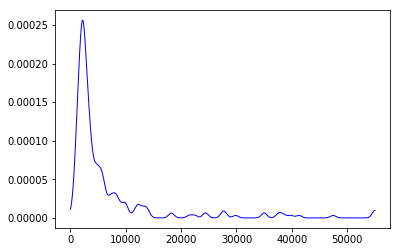

In [57]:
y_grid=np.linspace(np.amin(npa)-(np.amax(npa)-np.amin(npa))*0,np.amax(npa)+(np.amax(npa)-np.amin(npa))*0,1000)
ideal=1.06*(np.std(npa))*((len(npa)**(-1/5)))
pdf = kde_scipy(npa, y_grid, bandwidth=500)
plt.plot(y_grid, pdf, color='blue', alpha=1, lw=1)

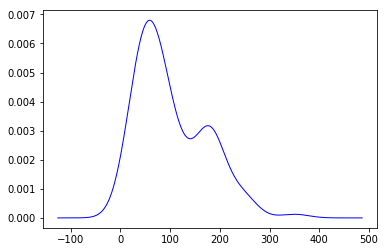

In [58]:
y_grid1=np.linspace(np.amin(npa1)-(np.amax(npa1)-np.amin(npa1))*0.4,np.amax(npa1)+(np.amax(npa1)-np.amin(npa1))*0.4,1000)
ideal1=1.06*(np.std(npa1))*((len(npa1)**(-1/5)))
pdf1 = kde_scipy(npa1, y_grid1, bandwidth=ideal1)
plt.plot(y_grid1, pdf1, color='blue', alpha=1, lw=1)

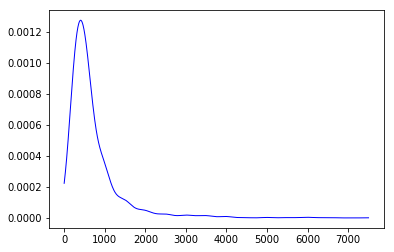

In [59]:
y_grid2=np.linspace(0,np.amax(npa2),1000)
ideal2=1.06*(np.std(npa2))*((len(npa2)**(-1/5)))
pdf2 = kde_scipy(npa2, y_grid2, bandwidth=ideal2)
plt.plot(y_grid2, pdf2, color='blue', alpha=1, lw=1)

In [62]:
w=((np.amax(npa)-np.amin(npa)))/1000
#w1=((np.amax(npa1)-np.amin(npa1))*1.8)/1000
#w2=np.amax(npa2)/1000
print(np.sum(pdf)*w)
#print(np.sum(pdf1)*w1,np.sum(pdf2)*w2)

0.9897678481595868


In [63]:
pdf_area=np.zeros(len(pdf)-1)
for a in range(len(pdf_area)):
    pdf_area[a]=(pdf[a]+pdf[a+1])*(w/2)
print(np.sum(pdf_area))

0.9891960441342237


In [65]:
localmaxima=argrelextrema(pdf, np.greater);localmaxima

(array([ 40, 143, 176, 223, 242, 331, 399, 443, 503, 542, 636, 688, 722,
        750, 862], dtype=int64),)

In [69]:
maxpos =np.where(pdf==max(pdf));maxpos

(array([40], dtype=int64),)

In [64]:
f_peak=localmaxima[0][0]
for q in range(f_peak):
    if np.sum(pdf[f_peak-q:f_peak+q])*w > 0.5:
        print(np.sum(pdf[f_peak-q:f_peak+q])*w,q)
    break
print((f_peak-q)*w+np.amin(npa)-(np.amax(npa)-np.amin(npa))*0.4,(f_peak+q)*w+np.amin(npa)-(np.amax(npa)-np.amin(npa))*0.4)

-19797.28 -19797.28


In [42]:
f_peak1=argrelextrema(pdf1, np.greater)[0][0]
q=0
for q in range(f_peak1):
  if np.sum(pdf1[f_peak1-q:f_peak1+2*q])*w1 > 0.5:
    print(np.sum(pdf1[f_peak1-q:f_peak1+2*q])*w1,q)
    break
print((f_peak1-q)*w1,(f_peak1+2*q)*w1)

0.5025572739312131 88
18.700000000000003 108.46000000000001


In [71]:
f_peak2=argrelextrema(pdf2, np.greater)[0][0]
for q in range(f_peak2):
  if np.sum(pdf2[f_peak2-q:f_peak2+q])*w2 > 0.6:
    print(np.sum(pdf2[f_peak2-q:f_peak2+q])*w2,q)
    break
print((f_peak2-q)*w2+np.amin(npa2),(f_peak2+q)*w2+np.amin(npa2))

0.6041638937693559 39
16.0 601.0


In [75]:
qq1=len(pdf)
for q in range(len(pdf)):
  for p in range(len(pdf)-(q+1)):
     if np.sum(pdf[p:p+q+1])*w > 0.5:
        print(np.sum(pdf[p:p+q+1])*w,p,q)
        break
  if np.sum(pdf[p:p+q+1])*w > 0.5:
    print(np.sum(pdf[p:p+q+1])*w,p,q)
    break
print((p)*w+np.amin(npa)-(np.amax(npa)-np.amin(npa))*0.4,(p+q+1)*w+np.amin(npa)-(np.amax(npa)-np.amin(npa))*0.4)  
     
        

0.5013962751878228 219 41
0.5013962751878228 219 41
359.9150000000009 4466.884999999998


In [78]:
qq2=len(pdf1)
for q in range(len(pdf1)):
  for p in range(len(pdf1)-(q+1)):
     if np.sum(pdf1[p:p+q+1])*w1 > 0.5:
        print(np.sum(pdf1[p:p+q+1])*w1,p,q)
        break
  if np.sum(pdf1[p:p+q+1])*w1 > 0.5:
    print(np.sum(pdf1[p:p+q+1])*w1,p,q)
    break
print((p)*w1+np.amin(npa1)-(np.amax(npa1)-np.amin(npa1))*0.4,(p+q+1)*w1+np.amin(npa1)-(np.amax(npa1)-np.amin(npa1))*0.4)  
 

0.5004084344413006 231 141
0.5004084344413006 231 141
15.371999999999986 102.27599999999998


In [80]:
qq3=len(pdf2)
for q in range(len(pdf2)):
  for p in range(len(pdf2)-(q+1)):
     if np.sum(pdf2[p:p+q+1])*w2 > 0.6:
        print(np.sum(pdf2[p:p+q+1])*w2,p,q)
        break
  if np.sum(pdf2[p:p+q+1])*w2 > 0.6:
    print(np.sum(pdf2[p:p+q+1])*w2,p,q)
    break
print((p)*w2+np.amin(npa2),(p+q+1)*w2+np.amin(npa2))

0.601064418557538 20 64
0.601064418557538 20 64
151.0 638.5


In [73]:
aqw=np.zeros(6)
aqw[1:2]

array([0.])

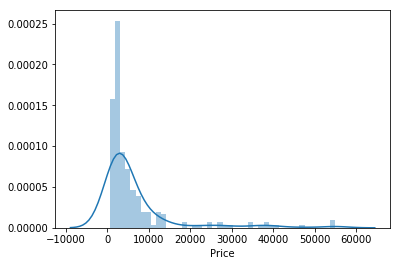

In [44]:
sns.distplot(drilldf['Price'][1:]);

In [45]:
sns.distplot(df_train['Price'][1:], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['Price'][1:], plot=plt)

NameError: ignored

In [0]:
plt.scatter(drilldf['Price'],array);

In [0]:
array=np.arange(247)+1;array